In [2]:
!pip install seaborn

In [4]:
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 20.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.4 MB/s eta 0:00:00


In [6]:
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00


In [8]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 21.9 MB/s eta 0:00:0000:0100:01


In [60]:
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pyarrow.parquet as pq


In [107]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

#  Load Multiple Months of NYC TLC Data
data_dir = "data/taxi/"
months = [f"2017-{str(m).zfill(2)}" for m in range(1, 13)]
all_dfs_train = []
columns = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'PULocationID', 'DOLocationID',
    'passenger_count', 'fare_amount', 'congestion_surcharge'
]

for month in months:
    file_path = os.path.join(data_dir, f"yellow_tripdata_{month}.parquet")
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path, columns=columns)
        df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        df['pickup_hour'] = df['pickup_datetime'].dt.hour
        df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
        df['pickup_zone'] = df['PULocationID']
        df['dropoff_zone'] = df['DOLocationID']
        df['day_type'] = df['pickup_datetime'].dt.day_name()
        all_dfs_train.append(df)

# Load January 2018 Yellow Taxi Data (Validation)
val_month = "2018-01"
val_df = pd.read_parquet(os.path.join(data_dir, f"yellow_tripdata_{val_month}.parquet"), columns=columns)
val_df['pickup_datetime'] = pd.to_datetime(val_df['tpep_pickup_datetime'])
val_df['dropoff_datetime'] = pd.to_datetime(val_df['tpep_dropoff_datetime'])
val_df['pickup_hour'] = val_df['pickup_datetime'].dt.hour
val_df['pickup_day'] = val_df['pickup_datetime'].dt.dayofweek
val_df['pickup_zone'] = val_df['PULocationID']
val_df['dropoff_zone'] = val_df['DOLocationID']
val_df['day_type'] = val_df['pickup_datetime'].dt.day_name()

# Combine
trips_df = pd.concat(all_dfs_train, ignore_index=True)
print("Training shape:", trips_df.shape)

# Find 50 most active drop-off zones
top_zones = trips_df['DOLocationID'].value_counts().head(50).index.tolist()
print("Top 50 most active drop-off zones:", top_zones)

# Keep only records where DOLocationID is in top zones
trips_df = trips_df[trips_df['DOLocationID'].isin(top_zones)]

# Filter val_df to same top zones
val_df = val_df[val_df['DOLocationID'].isin(top_zones)]

# One-hot encode day_type
day_type_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
day_type_encoded = day_type_encoder.fit_transform(trips_df[['day_type']])
day_type_encoded_val = day_type_encoder.transform(val_df[['day_type']])

Training shape: (47442571, 14)
Top 50 most active drop-off zones: [236, 161, 237, 170, 230, 162, 234, 186, 142, 48, 239, 79, 163, 141, 68, 107, 164, 238, 263, 246, 229, 140, 249, 231, 100, 90, 264, 113, 137, 233, 262, 143, 43, 75, 138, 114, 50, 148, 158, 144, 13, 211, 132, 151, 87, 166, 74, 41, 125, 261]


In [108]:
# Aggregate Demand and more features by hour and zone
grouped = trips_df.groupby(['dropoff_zone', pd.Grouper(key='dropoff_datetime', freq='1h')])
agg = grouped.agg(
    dropoff_count=('dropoff_zone', 'size'),
    avg_fare_amount=('fare_amount', 'mean'),
    avg_passenger_count=('passenger_count', 'mean'),
    avg_congestion_surcharge=('congestion_surcharge', 'mean')
).reset_index()

In [91]:
# Pivot for multivariate time series
agg_pivoted = agg.pivot(index='dropoff_datetime', columns='dropoff_zone')
agg_pivoted = agg_pivoted.fillna(0).infer_objects(copy=False)
# Flatten multi-index columns
agg_pivoted.columns = ['{}_{}'.format(metric, zone) for metric, zone in agg_pivoted.columns]
# Append one-hot encoded day_type to agg_pivoted
agg_pivoted_enriched = np.hstack([agg_pivoted.values, day_type_encoded[:agg_pivoted.shape[0]]])


# Validation
grouped_val = val_df.groupby(['dropoff_zone', pd.Grouper(key='dropoff_datetime', freq='1h')])
agg_val = grouped_val.agg(
    dropoff_count=('dropoff_zone', 'size'),
    avg_fare_amount=('fare_amount', 'mean'),
    avg_passenger_count=('passenger_count', 'mean'),
    avg_congestion_surcharge=('congestion_surcharge', 'mean')
).reset_index()

agg_pivoted_val = agg_val.pivot(index='dropoff_datetime', columns='dropoff_zone')
agg_pivoted_val = agg_pivoted_val.fillna(0).infer_objects(copy=False)
agg_pivoted_val = agg_pivoted_val.reindex(columns=agg_pivoted.columns, fill_value=0)
# Append one-hot encoded day_type to validation
agg_pivoted_val_enriched = np.hstack([agg_pivoted_val.values, day_type_encoded_val[:agg_pivoted_val.shape[0]]])

# Standardize Features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(agg_pivoted_enriched)
X_train_full = torch.tensor(scaled_data[:-1], dtype=torch.float)
y_train_full = torch.tensor(scaled_data[1:], dtype=torch.float)

scaled_val = scaler.transform(agg_pivoted_val_enriched)
X_val = torch.tensor(scaled_val[:-1], dtype=torch.float)
y_val = torch.tensor(scaled_val[1:], dtype=torch.float)

X_train, y_train = X_train_full, y_train_full

/tmp/ipykernel_100766/1059113365.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg_pivoted = agg_pivoted.fillna(0).infer_objects(copy=False)


In [92]:
# Extract zone ids and edge index from co-visitation 
zone_ids = sorted(set(trips_df['dropoff_zone'].unique()))
zone_to_idx = {z: i for i, z in enumerate(zone_ids)}

# Build co-visitation edges/graph
zone_transitions = trips_df.groupby(['pickup_zone', 'dropoff_zone']).size().reset_index(name='weight')
zone_transitions = zone_transitions[zone_transitions['pickup_zone'].isin(zone_ids) & zone_transitions['dropoff_zone'].isin(zone_ids)]
edge_index = torch.tensor(zone_transitions[['pickup_zone', 'dropoff_zone']].replace(zone_to_idx).values.T, dtype=torch.long)


In [93]:
# Print top co-visitation pairs (pickup - dropoff) by trip frequency
print(zone_transitions.sort_values(by='weight', ascending=False).head(10))

      pickup_zone  dropoff_zone  weight
8482          264           264  651193
7548          237           236  282057
7498          236           236  240837
7499          236           237  232102
7549          237           237  216895
7650          239           238  136358
7629          239           142  133062
4362          142           239  126484
7536          237           162  121714
7601          238           239  116235


In [94]:
class GNNRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, gnn_dim=32):
        super(GNNRNNModel, self).__init__()
        self.gcn = GCNConv(input_dim, gnn_dim)
        self.rnn = nn.GRU(gnn_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, edge_index):
        gnn_out = self.gcn(x, edge_index)
        rnn_input = gnn_out.unsqueeze(0)  # (1, time, features)
        rnn_out, _ = self.rnn(rnn_input)
        output = self.fc(rnn_out.squeeze(0))
        return output


In [95]:
# Train Model
model = GNNRNNModel(input_dim=X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
val_losses = []
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(X_train, edge_index)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Evaluate on validation
    model.eval()
    with torch.no_grad():
        val_out = model(X_val, edge_index)
        val_loss = loss_fn(val_out, y_val)
        val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch 0, Train Loss: 0.7768, Val Loss: 10.9647
Epoch 10, Train Loss: 0.6422, Val Loss: 8.1616
Epoch 20, Train Loss: 0.5258, Val Loss: 6.3743
Epoch 30, Train Loss: 0.4502, Val Loss: 5.2631
Epoch 40, Train Loss: 0.4058, Val Loss: 4.2165
Epoch 50, Train Loss: 0.3739, Val Loss: 3.2291
Epoch 60, Train Loss: 0.3508, Val Loss: 2.4202
Epoch 70, Train Loss: 0.3348, Val Loss: 1.8422
Epoch 80, Train Loss: 0.3236, Val Loss: 1.4328
Epoch 90, Train Loss: 0.3152, Val Loss: 1.1653
Epoch 100, Train Loss: 0.3086, Val Loss: 0.9762
Epoch 110, Train Loss: 0.3033, Val Loss: 0.8336
Epoch 120, Train Loss: 0.2987, Val Loss: 0.7131
Epoch 130, Train Loss: 0.2947, Val Loss: 0.6134
Epoch 140, Train Loss: 0.2909, Val Loss: 0.5152
Epoch 150, Train Loss: 0.2871, Val Loss: 0.4364
Epoch 160, Train Loss: 0.2862, Val Loss: 0.3800
Epoch 170, Train Loss: 0.2824, Val Loss: 0.3430
Epoch 180, Train Loss: 0.2775, Val Loss: 0.3238
Epoch 190, Train Loss: 0.2826, Val Loss: 0.3572


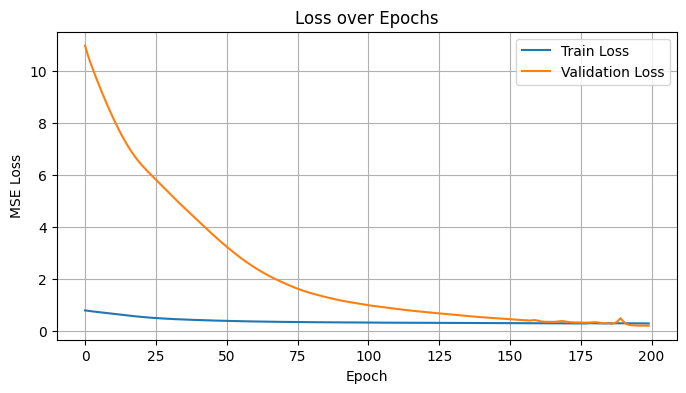

In [96]:
# Visualize Loss
plt.figure(figsize=(8,4))
plt.plot(losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

In [118]:
print(f"losses[200]: {val_losses[199]}")

losses[200]: 0.187575563788414


In [101]:
from sklearn.metrics import mean_absolute_error

# Truncate predictions to match ground truth shape
val_preds_trimmed = val_preds_np[:, :y_val_np.shape[1]]

# Compute MAE
mae = mean_absolute_error(y_val_np, val_preds_trimmed)
print(f"Validation MAE: {mae:.4f}")


Validation MAE: 0.3702


In [97]:
# Multi-Step Forecasting (for 3 steps in future)
model.eval()
horizon = 3
input_seq = X_train.clone()
predictions = []
for step in range(horizon):
    output = model(input_seq, edge_index)
    predictions.append(output[-1].unsqueeze(0))
    input_seq = torch.cat([input_seq[1:], output[-1].unsqueeze(0)])

multi_step_preds = torch.cat(predictions)
multi_step_preds_np = multi_step_preds.detach().numpy()
multi_step_preds_inv = scaler.inverse_transform(multi_step_preds_np)
multi_step_preds_inv = np.clip(multi_step_preds_inv, a_min=0, a_max=None)

print("Multi-step forecast shape:", multi_step_preds.shape)

Multi-step forecast shape: torch.Size([3, 200])


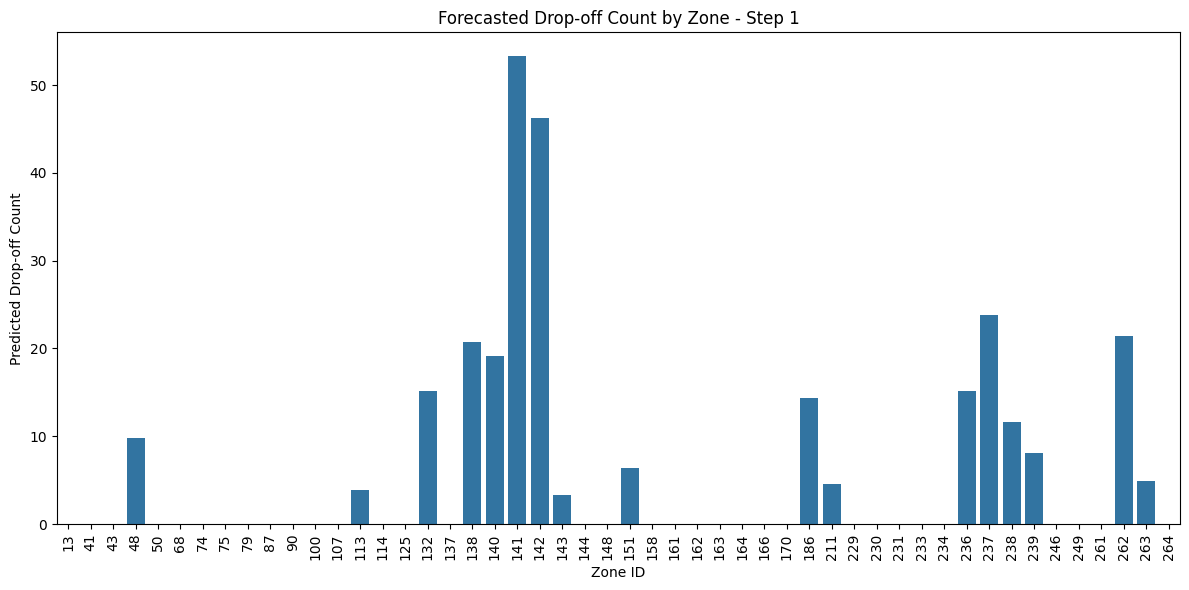

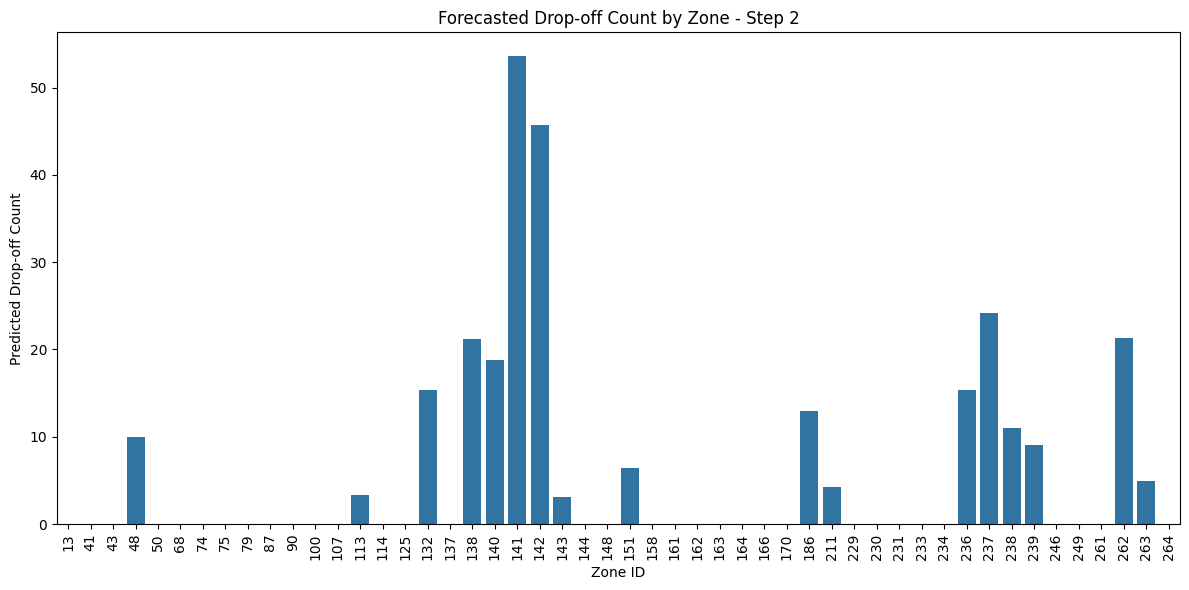

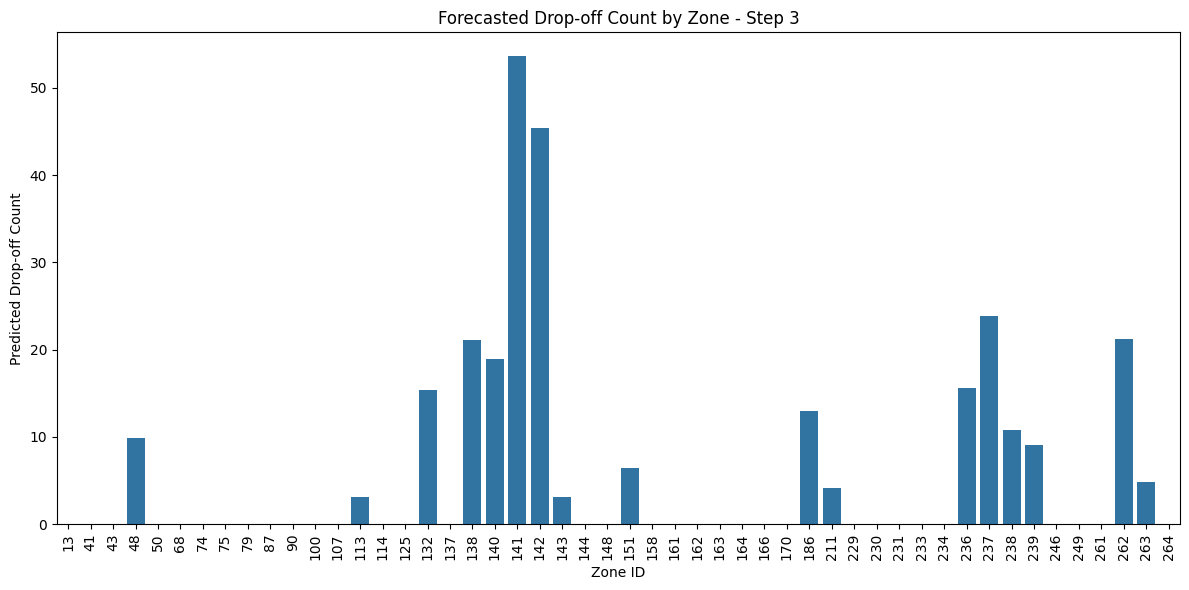

In [98]:
# Visualize Forecasted Zone Crowd Density Over Time (time steps)
multi_step_real = multi_step_preds_inv
feature_names = agg_pivoted.columns
zone_features = [name for name in feature_names if name.startswith("dropoff_count_")]
zone_indices = [feature_names.get_loc(name) for name in zone_features]

for step in range(horizon):
    values = multi_step_real[step, zone_indices]
    zone_ids_extracted = [int(name.split('_')[-1]) for name in zone_features]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=zone_ids_extracted, y=values)
    plt.title(f"Forecasted Drop-off Count by Zone - Step {step + 1}")
    plt.xlabel("Zone ID")
    plt.ylabel("Predicted Drop-off Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [89]:
import pandas as pd
def simulate_daytype_zone(model, X_seed, edge_index, scaler, feature_names, zone_id, day_type_encoder, target_daytype, horizon=24):
    """
    Simulates predictions for a specific zone assuming a fixed day of the week (e.g., Monday vs Saturday) by modifying the day-of-week encoding.
    Input: Trained model, last training window, zone ID, target_daytype (e.g., "Saturday")

    Purpose: Run forecast like predict_generic_day_zone, but inject a fixed weekday/weekend identity

    Modifies: Day-of-week one-hot encoding in input
    """
    zone_key = f"dropoff_count_{zone_id}"
    try:
        zone_index = feature_names.index(zone_key)
    except ValueError:
        print(f"Zone {zone_id} not found.")
        return

    # Get one-hot vector for target day (e.g., "Monday")
    day_vec = day_type_encoder.transform(pd.DataFrame({'day_type': [target_daytype]}))[0]

    # Calculate where the day-type features begin
    feature_start = X_seed.shape[1] - len(day_vec)

    # Clone seed input and inject target day-type into each time step
    input_seq = X_seed.clone()
    input_seq[:, feature_start:] = torch.tensor(day_vec, dtype=torch.float)

    # Step forward
    predictions = []
    model.eval()
    for _ in range(horizon):
        with torch.no_grad():
            output = model(input_seq, edge_index)
        predictions.append(output[-1].unsqueeze(0))

        # Replace day_type vector in the predicted next step
        next_input = output[-1].clone()
        next_input[feature_start:] = torch.tensor(day_vec, dtype=torch.float)
        input_seq = torch.cat([input_seq[1:], next_input.unsqueeze(0)])

    preds = torch.cat(predictions).detach().numpy()
    preds_inv = scaler.inverse_transform(preds)
    zone_preds = np.clip(preds_inv[:, zone_index], 0, None)

    # Plot
    hours = list(range(horizon))
    plt.figure(figsize=(10, 5))
    plt.bar(hours, zone_preds)
    plt.title(f"Predicted Dropoffs for Zone {zone_id} on {target_daytype}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Dropoff Count")
    plt.xticks(hours)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return list(zip(hours, zone_preds))


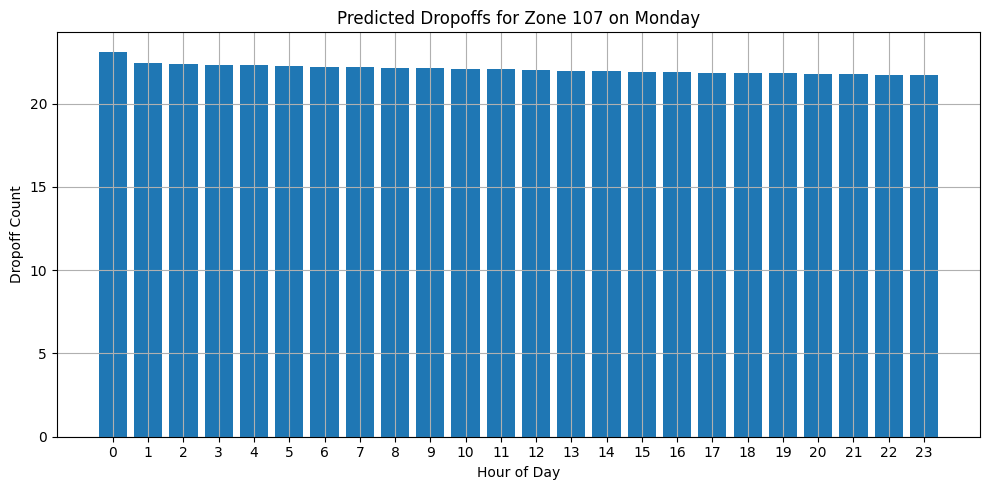

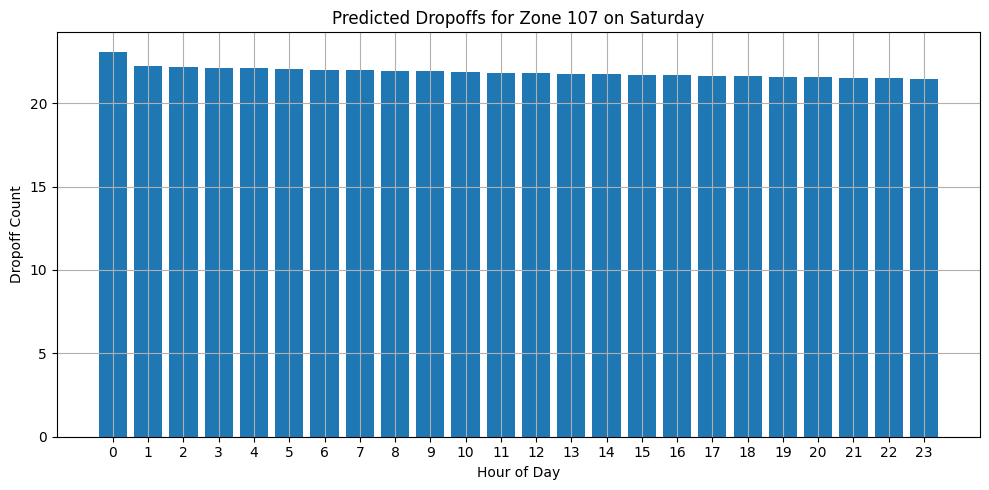

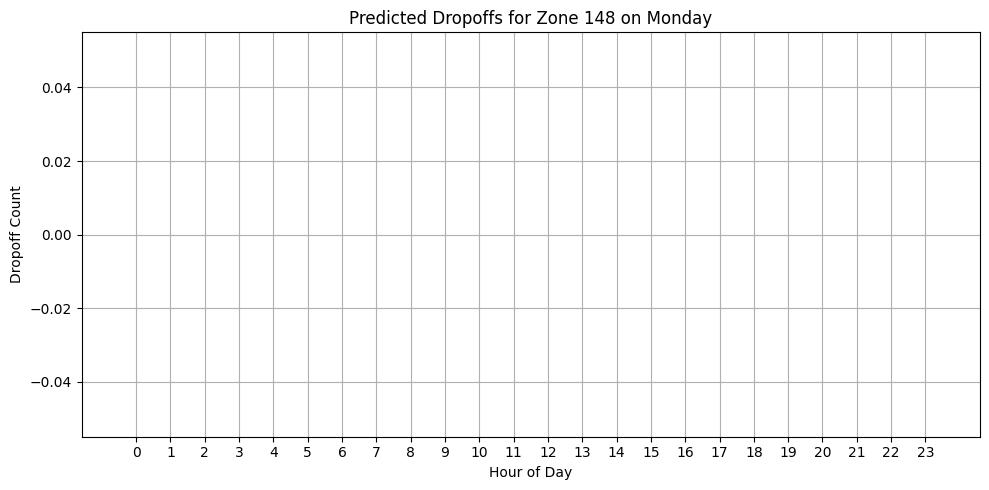

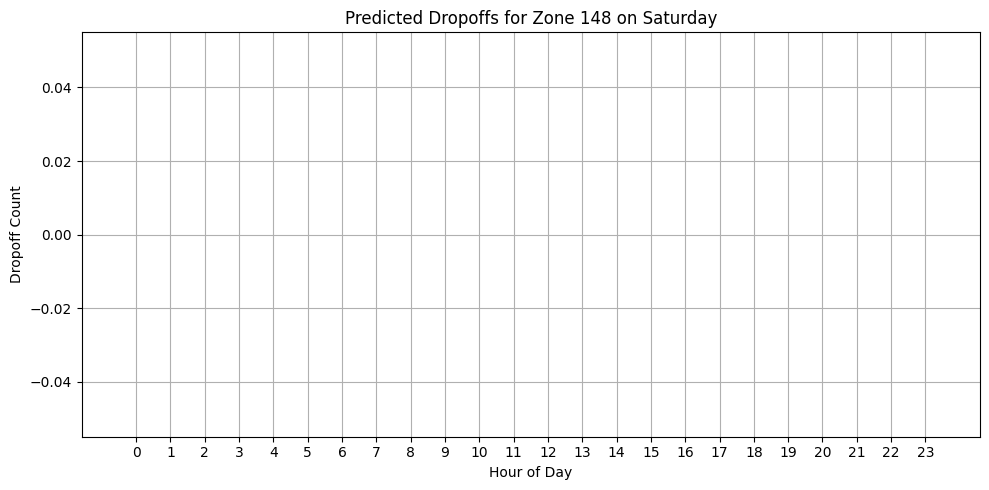

[(0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.0),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.0),
 (16, 0.0),
 (17, 0.0),
 (18, 0.0),
 (19, 0.0),
 (20, 0.0),
 (21, 0.0),
 (22, 0.0),
 (23, 0.0)]

In [90]:
simulate_daytype_zone(
    model=model,
    X_seed=X_train.clone(),
    edge_index=edge_index,
    scaler=scaler,
    feature_names=agg_pivoted.columns.tolist(),
    zone_id=107,
    day_type_encoder=day_type_encoder,
    target_daytype="Monday"  # Weekday
)

simulate_daytype_zone(
    model=model,
    X_seed=X_train.clone(),
    edge_index=edge_index,
    scaler=scaler,
    feature_names=agg_pivoted.columns.tolist(),
    zone_id=107,
    day_type_encoder=day_type_encoder,
    target_daytype="Saturday"  # Weekend
)

simulate_daytype_zone(
    model=model,
    X_seed=X_train.clone(),
    edge_index=edge_index,
    scaler=scaler,
    feature_names=agg_pivoted.columns.tolist(),
    zone_id=148,
    day_type_encoder=day_type_encoder,
    target_daytype="Monday"  # Weekday
)

simulate_daytype_zone(
    model=model,
    X_seed=X_train.clone(),
    edge_index=edge_index,
    scaler=scaler,
    feature_names=agg_pivoted.columns.tolist(),
    zone_id=148,
    day_type_encoder=day_type_encoder,
    target_daytype="Saturday"  # Weekend
)


In [76]:
import pandas as pd
def simulate_daytype_multi_zones(model, X_seed, edge_index, scaler, feature_names, zone_ids, day_type_encoder, target_daytype, horizon=24):
    """
    Predicts 24-hour dropoff counts for multiple zones on a given day-type (e.g., Monday).
    Plots all zones on one graph for easy comparison

    Useful for comparing weekday vs weekend behavior across zones
    """
    # Get one-hot day-type vector
    day_vec = day_type_encoder.transform(pd.DataFrame({'day_type': [target_daytype]}))[0]
    feature_start = X_seed.shape[1] - len(day_vec)

    # Inject day-type into seed input
    input_seq = X_seed.clone()
    input_seq[:, feature_start:] = torch.tensor(day_vec, dtype=torch.float)

    model.eval()
    predictions = []

    for _ in range(horizon):
        with torch.no_grad():
            output = model(input_seq, edge_index)
        predictions.append(output[-1].unsqueeze(0))

        # Inject fixed day-type for next step
        next_input = output[-1].clone()
        next_input[feature_start:] = torch.tensor(day_vec, dtype=torch.float)
        input_seq = torch.cat([input_seq[1:], next_input.unsqueeze(0)])

    preds = torch.cat(predictions).detach().numpy()
    preds_inv = scaler.inverse_transform(preds)

    # Plot all requested zones
    hours = list(range(horizon))
    plt.figure(figsize=(12, 6))
    for zone_id in zone_ids:
        zone_key = f"dropoff_count_{zone_id}"
        if zone_key not in feature_names:
            print(f"Zone {zone_id} not found, skipping.")
            continue
        zone_index = feature_names.index(zone_key)
        zone_preds = np.clip(preds_inv[:, zone_index], 0, None)
        plt.plot(hours, zone_preds, label=f"Zone {zone_id}", marker='o')

    plt.title(f"Predicted Dropoff Count on {target_daytype}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Dropoff Count")
    plt.xticks(hours)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


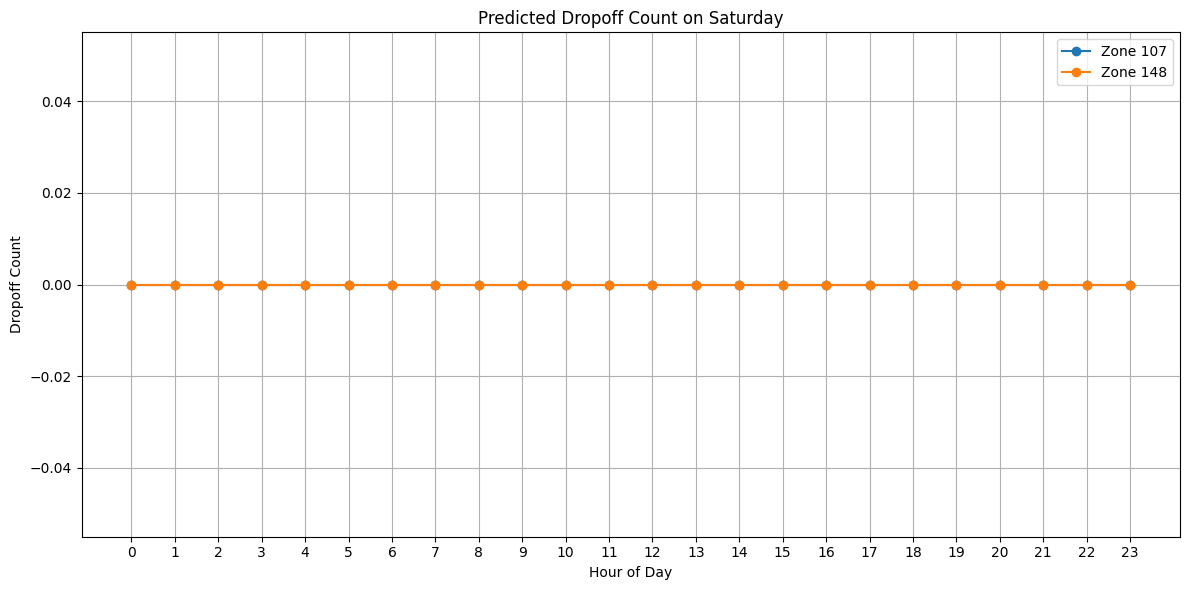

In [77]:
simulate_daytype_multi_zones(
    model=model,
    X_seed=X_train.clone(),
    edge_index=edge_index,
    scaler=scaler,
    feature_names=agg_pivoted.columns.tolist(),
    zone_ids=[107, 148],
    day_type_encoder=day_type_encoder,
    target_daytype="Saturday",  # or "Monday"
    horizon=24
)


In [41]:
def predict_generic_day_zone(model, X_seed, edge_index, scaler, feature_names, zone_id, horizon=24):
    """
    Predict dropoff counts for a specific zone over 24 future hours using the model.
    Simulates a generic day by forecasting from the end of training data.

    
    """
    zone_key = f"dropoff_count_{zone_id}"
    try:
        zone_index = feature_names.index(zone_key)
    except ValueError:
        print(f"Zone {zone_id} not found in features.")
        return

    model.eval()
    input_seq = X_seed.clone()
    predictions = []

    for _ in range(horizon):
        with torch.no_grad():
            output = model(input_seq, edge_index)
        predictions.append(output[-1].unsqueeze(0))
        input_seq = torch.cat([input_seq[1:], output[-1].unsqueeze(0)])

    # Concatenate and inverse transform
    preds = torch.cat(predictions).detach().numpy()
    preds_inv = scaler.inverse_transform(preds)
    zone_preds = np.clip(preds_inv[:, zone_index], 0, None)

    # Plot
    hours = list(range(horizon))
    plt.figure(figsize=(10, 5))
    plt.bar(hours, zone_preds)
    plt.title(f"Predicted Dropoff Count for Zone {zone_id} on a Generic Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Predicted Dropoffs")
    plt.xticks(hours)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return list(zip(hours, zone_preds))


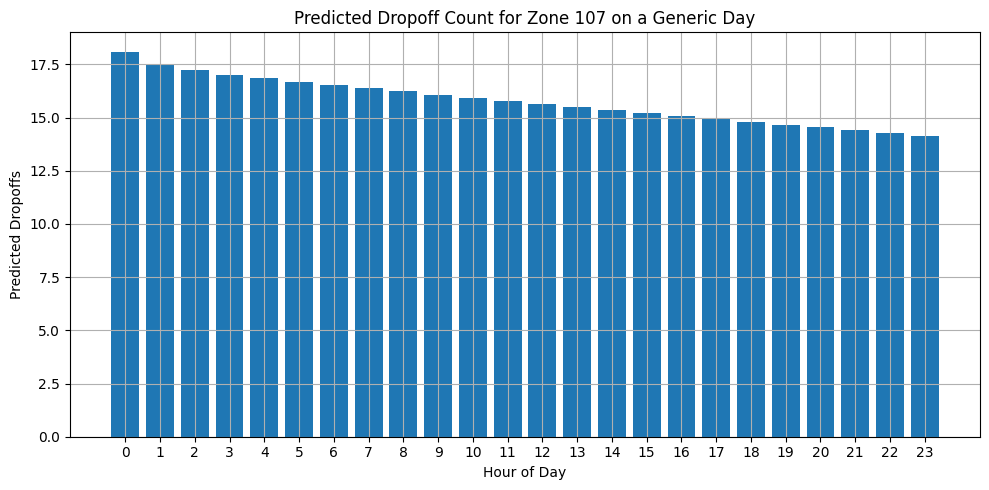

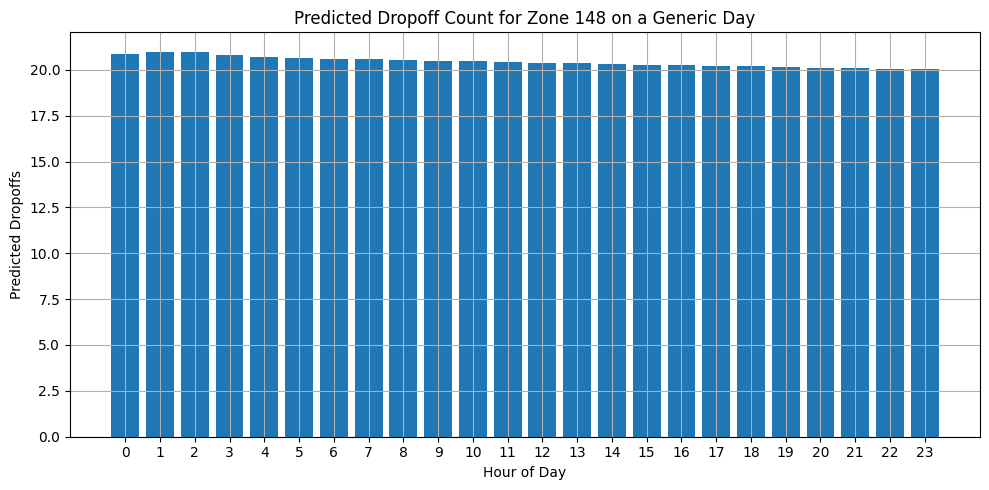

[(0, 20.833874),
 (1, 20.992222),
 (2, 20.946758),
 (3, 20.819813),
 (4, 20.724545),
 (5, 20.658588),
 (6, 20.608898),
 (7, 20.567135),
 (8, 20.528957),
 (9, 20.492512),
 (10, 20.45683),
 (11, 20.421658),
 (12, 20.386784),
 (13, 20.352207),
 (14, 20.317898),
 (15, 20.283947),
 (16, 20.250301),
 (17, 20.216915),
 (18, 20.183933),
 (19, 20.151226),
 (20, 20.118916),
 (21, 20.086887),
 (22, 20.055248),
 (23, 20.0239)]

In [42]:
predict_generic_day_zone(
    model=model,
    X_seed=X_train.clone(),
    edge_index=edge_index,
    scaler=scaler,
    feature_names=agg_pivoted.columns.tolist(),
    zone_id=107,
    horizon=24
)

predict_generic_day_zone(
    model=model,
    X_seed=X_train.clone(),
    edge_index=edge_index,
    scaler=scaler,
    feature_names=agg_pivoted.columns.tolist(),
    zone_id=148,
    horizon=24
)
